<a href="https://colab.research.google.com/github/anuradhasurabhi/RNN/blob/master/RNN_Arithmentic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making Your RNN Model Learn Arithmetic Operations!
Problem:

Given the string "34+17", the model should return a prediction: "51". Like addition the input string can also be subtraction, multiplication and division of numbers. Here we are giving input as a sequence of characters and expecting output is also a sequence of characters, and that will be predicted as a next string to the given string.

Importing necessary Libraries

In [21]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

from termcolor import colored

**Task 1: Generate Data**
___
First of all define the vocabulary with all the possible characters of input string as a list. Thus the vocabulary should consists of 0 to 9 digits, symbols: +, -, *, / and decimal(.). 

The model that you create need numeric values in tensors as input. We need a suitable representation of these sequence of characters to input to model. We  do this by converting characters to one-hot encoding vectors. The dimension of the vector will be equal to length of vocabulary. That will be the total number of features that we have. We need a dictionary that might be used to tokenize characters into numeric values for this purpose and also a reverse dictionary with index values as keys and corresponding characters as values, that might be used in later steps .
___

In [22]:
vocabulary ='0123456789+-*/.'
print('Vocabulary: ', vocabulary)
num_features = len(vocabulary)   ## define total number of features in the list; length of list
print('Number of features:', num_features)   ## print the number of features 


Vocabulary:  0123456789+-*/.
Number of features: 15


In [23]:
char_to_index = dict((c, i) for i, c in enumerate(vocabulary))
index_to_char = dict((i, c) for i, c in enumerate(vocabulary))
print('char_to_index : ', char_to_index)
print('index_to_char : ', index_to_char)

char_to_index :  {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, '-': 11, '*': 12, '/': 13, '.': 14}
index_to_char :  {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '+', 11: '-', 12: '*', 13: '/', 14: '.'}


Now lets generate the data which is an single expression, result pair by defining a function. For this first create two numbers: 'first' and 'second' using 'np.random.randint(low, high)' and then create *expression* as the concatenation of stringified first and stringified second numbers. Similary create the *result* as stringingified 'first+second'. Sameway define for remaining operations also. Then the function should return created expression, result pair. 

In [24]:
def weird_division(n, d):
    return n / d if d else 0

def generate_data():
    first_num = np.random.randint(low=0,high=100)
    second_num = np.random.randint(low=0,high=100)
    add = np.random.randint(low=0, high=100) 
    if add <25:
        expression = str(first_num) + '+' + str(second_num)
        result = str(first_num+second_num)
    elif add in range(26,50):
        expression = str(first_num) + '-' + str(second_num)
        result = str(first_num-second_num)
    elif add in range(50,75):
        expression = str(first_num) + '*' + str(second_num)
        result = str(first_num*second_num)
    else:
        expression = str(first_num) + '/' + str(second_num)
        res = weird_division(first_num, second_num)
        result = str(round(res,2))


    return expression, result

generate_data()

('91*41', '3731')

**Task 2: Create the Model**

The model is keara's sequential with two parts: encoder and decoder. Encoder part is a SimpleRNN layer with hidden_units=128 and 'num_features' which is a fully connected RNN layer and the outputs of these units fed back to the network, it uses 'tanh' activation by default. The output of this layer will be a single vector representation and to achieve the single vector representation of the entire output, we will use the RepeatVector() layer with 'max_time_steps' repeated. 

This vector representation is the input to the Decoder section. Decoder consists of another SimpleRNN layer which takes vector representation of the input and generates predicted sequence. So, define this layer with 'hidden_units' and set 'return_sequences' to 'True'. 

The output of this RNN is a sequence which will go to a Dense layer with 'softmax' activation function. So, that the output will be various possibilities for various characters at each time step. 

As we need to apply Dense layer to individual time steps, we will encapsulate Dense layer inside a TimeDistribute layer, hidden state is different for different time steps. We want probability distribution for our characters 'num_features'

In [27]:
hidden_units = 128
max_time_steps = 5    # maximum length of input sequence
def rnn_model():
  rnn_model = Sequential()
  rnn_model.add(SimpleRNN(hidden_units, input_shape=(None, num_features)))
  rnn_model.add(RepeatVector(max_time_steps))
  rnn_model.add(SimpleRNN(hidden_units, return_sequences=True))
  rnn_model.add(TimeDistributed(Dense(num_features, activation='softmax')))
  
  return rnn_model

model = rnn_model()
model.summary()
 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 128)               18432     
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 5, 128)            0         
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 5, 128)            32896     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 5, 15)             1935      
Total params: 53,263
Trainable params: 53,263
Non-trainable params: 0
_________________________________________________________________


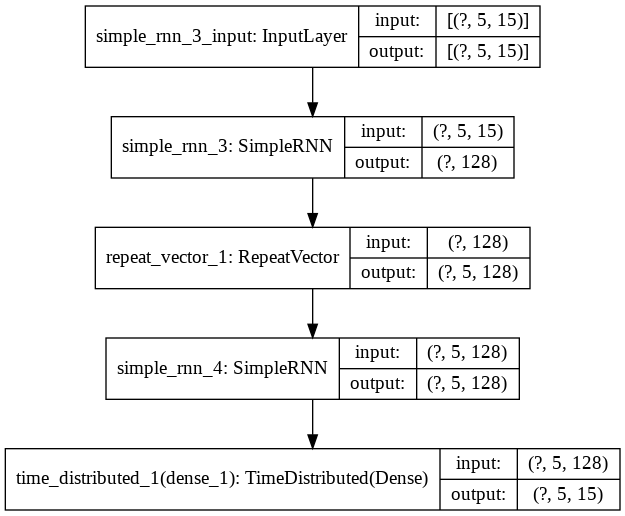

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Task 3: Vectorize, De-Vectorize Data and remove padding**
___
We need to vectorize the data so that it can be used in our RNN model. Define a function that vectorizes the given (expression, result) pair. In this function create a couple of place holders for the expression and result each with shapes (max_time_steps, num_features) and initialize with zero's. 

In [ ]:
def vectorize_example(expression, result): 
    
    x = np.zeros((max_time_steps, num_features))                   
    y = np.zeros((max_time_steps, num_features))
    
    diff_x = max_time_steps - len(expression)                         
    diff_y = max_time_steps - len(result)                           
    
    for i, c in enumerate(expression):           
        x[diff_x+i, char_to_index[c]] = 1     
    for i in range(diff_x):                   
        x[i, char_to_index['0']] = 1         
   
    for i, c in enumerate(result):
        y[diff_y+i, char_to_index[c]] = 1
    for i in range(diff_y):
        y[i, char_to_index['0']] = 1
        
    return x, y


Define a function to devectorize 'expression' and 'result' back. Create a list by using 'index_to_char' dictionary with relevant indices to convert indices back into characters. Use 'np.argmax()' to pick the maximum index value by enumerating over 'example'

In [29]:
def devectorize_example(example):
    result = [index_to_char[np.argmax(vec)] for i, vec in enumerate(example)]
    return ''.join(result)

If the expression and result pair is like '3-34','-31' then vectorized and devectorized results should be like '03-34', '00-31'. We can remove padded zeros while displaying the output results. 

In [30]:
def strip_padding(example):
    encountered_non_zero = False
    output = ''
    for c in example:
        if not encountered_non_zero and c == '0':
            continue
        if c == '+' or c == '-' or c=='*' or c=='/' or c=='.':
            encountered_non_zero = False
        else:
            encountered_non_zero = True
        output += c
    return output

**Task 4: Create Dataset**
___
We have defined a function to create a single (expression, result) pair. Now we need to create an entire dataset to train the model. Define a function to create dataset with a num_examples.

In [ ]:
def create_dataset(num_examples):

    x_train = np.zeros((num_examples, max_time_steps, num_features))            
    y_train = np.zeros((num_examples, max_time_steps, num_features))            

    for i in range(num_examples):                                               
        e, l = generate_data()                                                  
        x, y = vectorize_example(e, l)                                          
        x_train[i] = x                                                          
        y_train[i] = y                                                          
    
    return x_train, y_train


**Task 5: Training and Evaluating the model**

In [48]:
x_train, y_train = create_dataset(50000)
simple_logger = LambdaCallback(
    on_epoch_end=lambda e, l: print('{:.2f}'.format(l['val_accuracy']), end=' _ ')
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0, 
           callbacks=[simple_logger, early_stopping])

0.84 _ 0.84 _ 0.85 _ 0.86 _ 0.84 _ 0.84 _ 0.85 _ 0.85 _ 0.85 _ 0.86 _ 0.86 _ 0.85 _ 0.85 _ 0.86 _ 0.86 _ 0.86 _ 0.86 _ 0.85 _ 0.86 _ 0.85 _ 0.86 _ 0.86 _ 0.86 _ 0.85 _ 0.86 _ 0.86 _ 0.86 _ 0.86 _ 0.86 _ 0.86 _ 0.86 _ 

**Predictions:**

In [49]:
x_test, y_test = create_dataset(num_examples=20)
preds = model.predict(x_test)
full_seq_acc = 0

for i, pred in enumerate(preds):
    pred_str = strip_padding(devectorize_example(pred))
    y_test_str = strip_padding(devectorize_example(y_test[i]))
    x_test_str = strip_padding(devectorize_example(x_test[i]))
    col = 'green' if pred_str == y_test_str else 'red'
    full_seq_acc += 1/len(preds) * int(pred_str == y_test_str)
    outstring = 'Input: {}, Output: {}, Prediction: {}'.format(x_test_str, y_test_str, pred_str)
    print(colored(outstring, col))
print('\nFull sequence accuracy: {:.3f} %'.format(100 * full_seq_acc))

Input: 38*77, Output: 2926, Prediction: 2846
Input: 33*37, Output: 1221, Prediction: 1191
Input: 86-56, Output: 30, Prediction: 30
Input: 72-43, Output: 29, Prediction: 29
Input: 75/19, Output: 3.95, Prediction: 3.95
Input: 37+90, Output: 127, Prediction: 127
Input: 48-16, Output: 32, Prediction: 32
Input: 95+25, Output: 120, Prediction: 120
Input: 61-74, Output: -13, Prediction: -13
Input: 99+39, Output: 138, Prediction: 138
Input: 50*72, Output: 3600, Prediction: 3600
Input: 4-70, Output: -66, Prediction: -66
Input: 22/80, Output: .28, Prediction: .26
Input: 6/82, Output: .7, Prediction: .7
Input: 4/45, Output: .9, Prediction: .9
Input: 56*68, Output: 3808, Prediction: 3768
Input: 57-7, Output: 50, Prediction: 52
Input: 15+63, Output: 78, Prediction: 78
Input: 6*81, Output: 486, Prediction: 416
Input: 10+80, Output: 90, Prediction: 90

Full sequence accuracy: 70.000 %
